## Setup

In [1]:
import os, sys
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

In [2]:
destination = os.path.join(os.environ.get('nnUNet_raw'), os.environ.get('TotalBinary'))
assert os.path.exists(destination), f"Destination folder {destination} does not exist"

gt_path_for_anatomy = lambda x: os.path.join(os.environ.get('nnUNet_raw'), os.environ.get(x), os.environ.get('data_trainingLabels'))
gt_path_for_each_anatomy = dict([(os.environ.get(x), gt_path_for_anatomy(x)) for x in ['Anorectum','Bladder','CTVn','CTVp','Parametrium','Uterus','Vagina']])
assert all([os.path.exists(x) for x in gt_path_for_each_anatomy.values()])

In [3]:
# gt_combined = os.path.join(destination, os.environ.get('data_trainingLabels'))

img = os.path.join(destination, os.environ.get('data_trainingImages'), 'zzAMLART_001_0000.nii.gz')
gt_all = [os.path.join(os.environ.get('nnUNet_raw'), os.environ.get(x), os.environ.get('data_trainingLabels'), 'zzAMLART_001.nii.gz') for x in [
    'Anorectum', 'Bladder', 'CTVn', 'CTVp', 'Parametrium', 'Vagina', 'Uterus', 'TotalBinary'
]]

assert all([os.path.exists(x) for x in gt_all]), f'file not found in gt_all'
assert os.path.exists(img), f'file not found: {img}'

## Get segmented class ids

In [4]:
# read the dataset.json file
import json

dataset_file = os.path.join(destination, 'dataset.json')

with open(dataset_file, 'r') as f:
    dataset = json.load(f)

# dataset['labels']

In [5]:
def reverse_lookup_id(id : int):
    # given a dictinoary of key: anatomy, and value: segmentation ids, reverse the lookup to get the list of anatomies that match the id.

    if id == 0:
        return ['background']

    anatomies = []
    for k, v in dataset['labels'].items():
        if k == 'background':
            continue
        
        if id in v:
            anatomies.append(k)
    return anatomies

## Read in the image, disaply each slice along an axis

In [6]:
axis = 1

In [7]:
import numpy as np
import SimpleITK as sitk

image_arr = sitk.GetArrayFromImage(sitk.ReadImage(img))
gt_arrs = [ (i + 1 if i != 7 else 1) * sitk.GetArrayFromImage(sitk.ReadImage(x)) for i, x in enumerate(gt_all)]

segmentation_ids = list(np.unique(gt_arrs[-1]))

In [8]:
if axis == 1:
    image_arr = np.flipud(image_arr)
    gt_arrs = [np.flipud(x) for x in gt_arrs]

In [9]:
def slice_at(slice_id):
    slices = [slice(None)] * 3
    slices[axis] = slice_id
    return tuple(slices)

In [10]:
# get the range of indicies where there exists a segmentation along that axis
slice_index = []
for i in range(gt_arrs[-1].shape[axis]):
    slices = slice_at(i)
    my_slice = gt_arrs[-1][slices]
    if np.any(my_slice):
        slice_index.append(i)

In [11]:
random_slice = np.random.choice(slice_index)
random_slice, axis

(289, 1)

In [12]:
image_slice = image_arr[slice_at(random_slice)]
gt_slices = [x[slice_at(random_slice)].astype(np.uint8) for x in gt_arrs]

In [13]:
# Find contours in the segmentation map
import cv2

contours, _ = cv2.findContours(gt_slices[-1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
box_padding = 50

x_min, x_max, y_min, y_max = float('inf'), -float('inf'), float('inf'), -float('inf')

# Loop through contours to find bounding boxes
for contour in contours:
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(contour)
    x_min = min(x_min, x - box_padding)
    y_min = min(y_min, y - box_padding)
    x_max = max(x_max, x + w + box_padding)
    y_max = max(y_max, y + h + box_padding)

# crop the image slice to the region where the gt_slice is non-zero
image_slice_cropped = image_slice[y_min:y_max, x_min:x_max]
gt_slices_cropped = [x[y_min:y_max, x_min:x_max] for x in gt_slices]

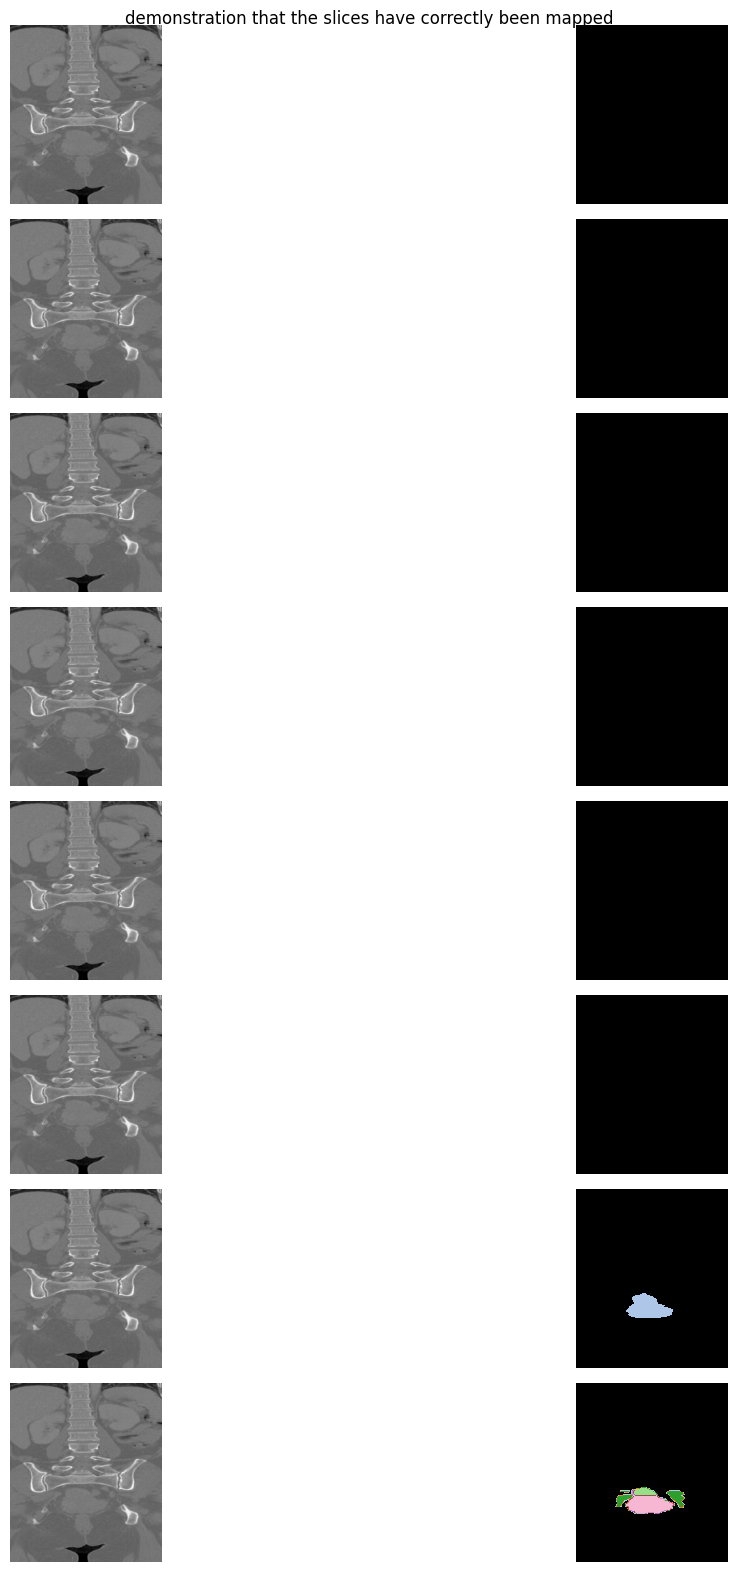

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Generate a custom colormap with vibrant colors for segmentation IDs
colors = plt.cm.tab20(np.linspace(0, 1, len(segmentation_ids)))
colors[0] = (0, 0, 0, 1)  # Set 0 to black
cmap = plt.cm.colors.ListedColormap(colors)

fig, ax = plt.subplots(len(gt_all), 2, figsize=(16,16))
for i in range(len(gt_all)):
    ax[i, 0].imshow(image_slice_cropped, cmap='gray')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(gt_slices_cropped[i], cmap=cmap, vmin = 0, vmax=max(segmentation_ids))
    ax[i, 1].axis('off')

# Create legend handles and labels
# legend_handles = [Patch(color=c, label=f'Segmentation ID {sid}: {reverse_lookup_id(sid)}') for sid, c in zip(segmentation_ids, colors)]
# ax[0, 1].legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(2.5, 1))

plt.suptitle('demonstration that the slices have correctly been mapped')
plt.tight_layout()
plt.show()
